In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression, RANSACRegressor

from glob import glob
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
import pandas as pd
import glob
import os

all_files = glob.glob("*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

allDF = pd.concat(li, axis=0, ignore_index=True)

In [3]:
# Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
# Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])

# Ux_TAO = np.array(subDF['mean_U10N_x'])
# Uy_TAO = np.array(subDF['mean_U10N_y'])

# QS = Ux_QS + 1j * Uy_QS
# TAO = Ux_TAO + 1j *Uy_TAO

# r = QS/TAO
# angle = np.angle(r, deg=True)
# ratio = np.abs(r)
# subDF['angle_diff'] = angle
# subDF['ratio'] = ratio

In [4]:
allDF.keys()

Index(['Wind Direction (TAO)', 'WDIR_QC', 'WDIR_DM', 'Wind Speed (TAO)',
       'WSPD_QC', 'WSPD_DM', 'Zonal Wind Speed (TAO)',
       'Meridional Wind Speed (TAO)', 'Sea Surface Temperature (TAO)',
       'SST_QC', 'SST_DM', 'Relative Humidity (TAO)', 'RELH_QC', 'RELH_DM',
       'Air Temperature (TAO)', 'AIRT_QC', 'AIRT_DM',
       'Neutral Wind Speed at 10m (TAO)', 'Wind Speed at 10m (TAO)',
       'mean_WSPD', 'std_WSPD', 'mean_WSPD_10N', 'std_WSPD_10N', 'mean_SST',
       'std_SST', 'mean_AIRT', 'std_AIRT', 'mean_RELH', 'std_RELH',
       'mean_U10N_x', 'std_U10N_x', 'mean_U10N_y', 'std_U10N_y',
       'mean_cosWDIR', 'std_cosWDIR', 'mean_sinWDIR', 'std_sinWDIR',
       'LATITUDE', 'LONGITUDE', 'TAO_TIME', 'Deployment index',
       'Wind Speed (QuikSCAT)', 'Wind Direction (QuikSCAT)', 'rain_impact',
       'flags', 'eflags', 'nudge_wind_speed', 'nudge_wind_direction',
       'retrieved_wind_speed_uncorrected', 'cross_track_wind_speed_bias',
       'atmospheric_speed_bias', 'wind_

In [5]:
allDF['Wind Direction (QuikSCAT)']

0         126.288025
1         126.834961
2         131.709473
3         120.591125
4         121.500000
             ...    
142632    198.994461
142633    198.238876
142634    210.359314
142635    205.006851
142636    204.803024
Name: Wind Direction (QuikSCAT), Length: 142637, dtype: float64

In [6]:
corrected_angle_diff = (allDF['corrected_angle_diff'] +360)%360
corrected_angle_diff[corrected_angle_diff>180] = corrected_angle_diff - 360
allDF['corrected_angle_diff'] = corrected_angle_diff
allDF['corrected_mean_TAO_WDIR'] = allDF['Wind Direction (QuikSCAT)'] -  allDF['corrected_angle_diff']
allDF['corrected mean_U10N_x'] = np.array(allDF['mean_WSPD_10N']) * np.cos(np.deg2rad(allDF['corrected_mean_TAO_WDIR']))
allDF['corrected mean_U10N_y'] = np.array(allDF['mean_WSPD_10N']) * np.sin(np.deg2rad(allDF['corrected_mean_TAO_WDIR']))

allDF['corrected cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(allDF['corrected_angle_diff']))
allDF['corrected sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(allDF['corrected_angle_diff']))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

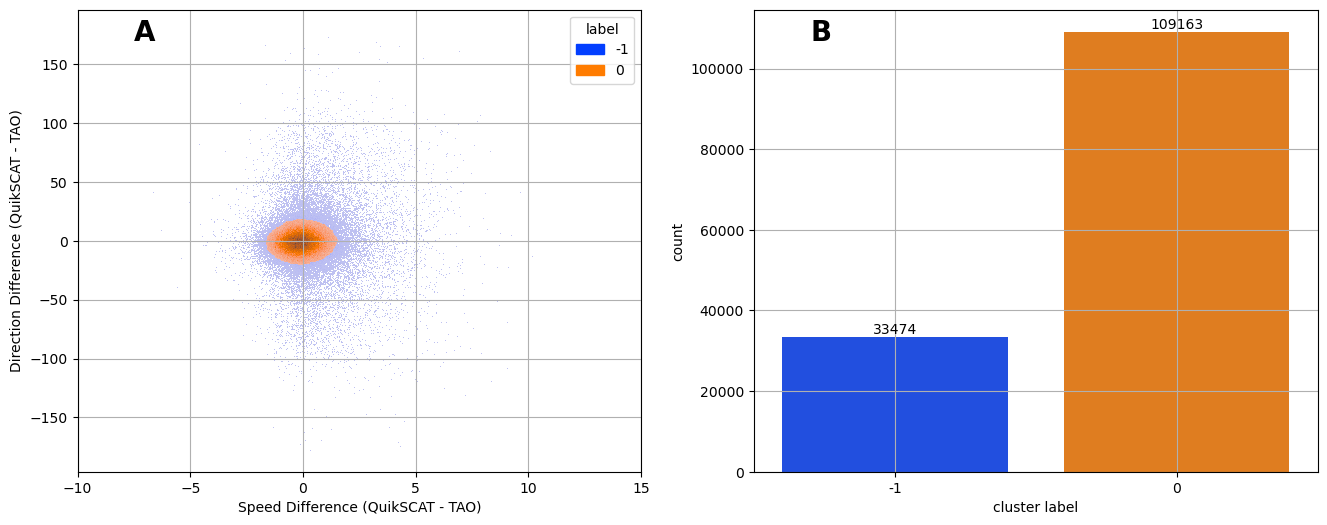

In [7]:
df = allDF.copy()

selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=17, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

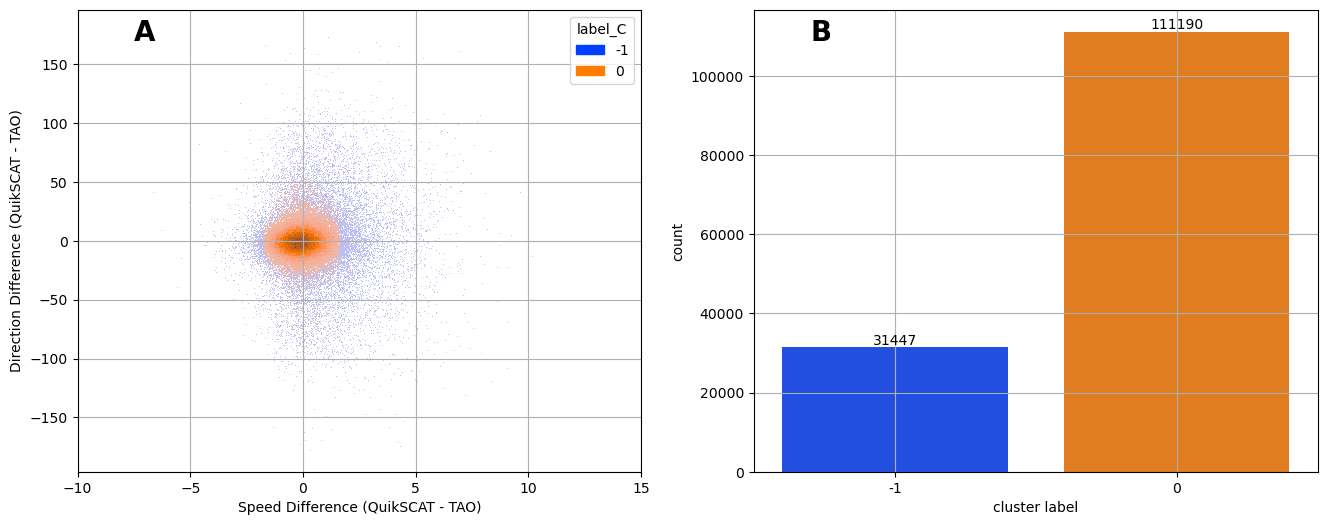

In [8]:
df = allDF.copy()

selectX = ['Speed Difference (QuikSCAT - TAO)',
          'corrected cos(Direction Difference (QuikSCAT - TAO))',
          'corrected sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=17, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label_C'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label_C', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label_C',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

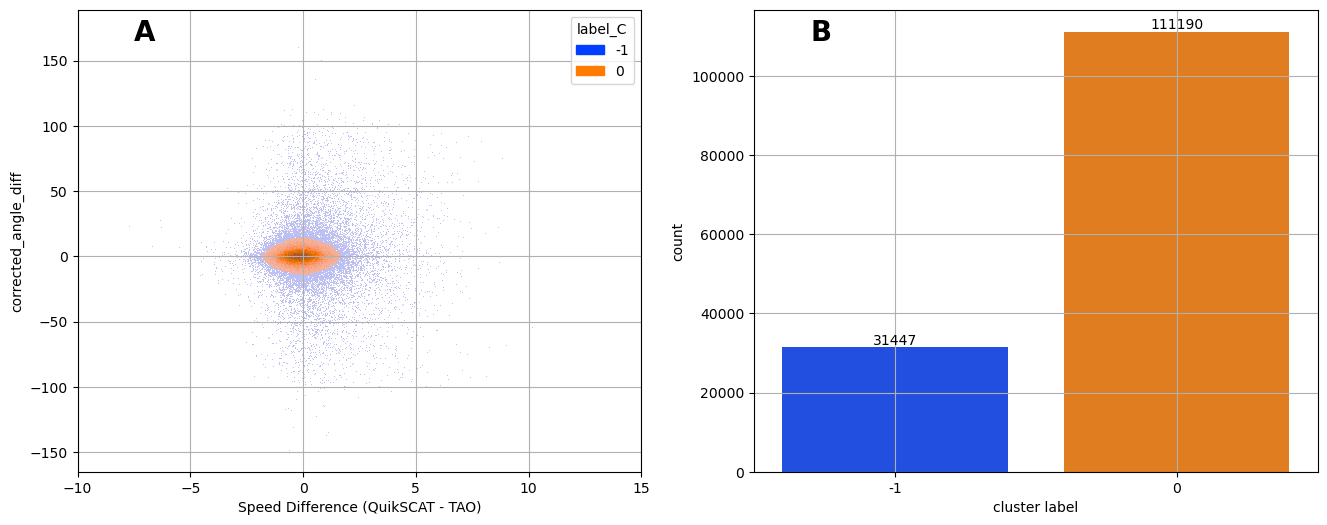

In [10]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'corrected_angle_diff'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label_C', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label_C',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)